# A first look at image classification with ConvNets

We will take a look at using convolutional layers inside a neural network. In particular, we will work on classifying X-ray images of lungs as normal or having pneumonia.
This part of the notebook is based in parts on a Kaggle tutorial by [Madhav Mathur](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy).

If you haven't done so, you will need to install opencv with the following line (note that the import uses `cv2` instead of the full name). In Colab, this is not needed.

We have a number of imports to do. You should be familiar with all of those, except `cv`, `Model`, `Conv2D`, `MaxPool2D`, `ImageDataGenerator`, and `ReduceLROnPlateau` which we introduce throughout the notebook.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Loading data

If we run things in Colab (highly recommended), the best way is to upload the Zip-file "chest_xray.zip" directly to Google Drive, then access Google Drive from Colab with the following command (you may need to give permissions):

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Then, you need to unzip the file within drive:

In [ ]:
!unzip gdrive/MyDrive/Deep_learning/chest_xray.zip

The Zip-file contains the following data set: [Kermany, Zhang, Goldbaum (2018)"Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification"](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Note that we have somewhat shifted around images from the test to the validation set (the original validation set only contains 16 images).

The function below takes any of the subdirectories (`'train'`, `'val'`, `'test'`), it then
1. Reads in the images (interpreted as being in grayscale), using `cv2`
1. Resizes them according to a pre-defined `img_size`
1. Reshapes the images to be three-dimensional each (with one channel instead of three, as we have grayscale images, not RGB images). Hence, our overall X's are 4-dimensional.
1. Normalizes the pixel values to the 0-1 interval
1. Returns the image data and the corresponding label as 0 (normal) or 1 (pneumonia)

In [4]:
labels = ['NORMAL','PNEUMONIA']
img_size = 200

def load_data_aux(img, path):
    try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) ## reshape images to preferred size (given as an input)
        return resized_arr
    except Exception as e:
        print(e)

def load_data(data_dir):
    x_data = [] 
    y_data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        img_files = [f for f in os.listdir(path) if not f.startswith('.')]
        x_data = x_data + [load_data_aux(img, path) for img in img_files]
        y_data = y_data + [class_num] * len(img_files)
    x = np.stack(x_data,axis=0).reshape(-1,img_size,img_size,1) ## reshape data to 4-dim array (observations, image width, image heigh, image channels)
    x = x / 255 ## normalize data to 0-1
    y = np.array(y_data,dtype='float32')    
    return x, y

We call the previous function in order to load the three data sets:

In [5]:
x_train, y_train = load_data('chest_xray/train')
x_val, y_val = load_data('chest_xray/val')
x_test, y_test = load_data('chest_xray/test')

In [6]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(5216, 200, 200, 1)
(16, 200, 200, 1)
(624, 200, 200, 1)


Let's take a look at the labels on the training data. it seems that there are many more images with pneumonia than without, but the order of magnitude is similar, so this should be okay:

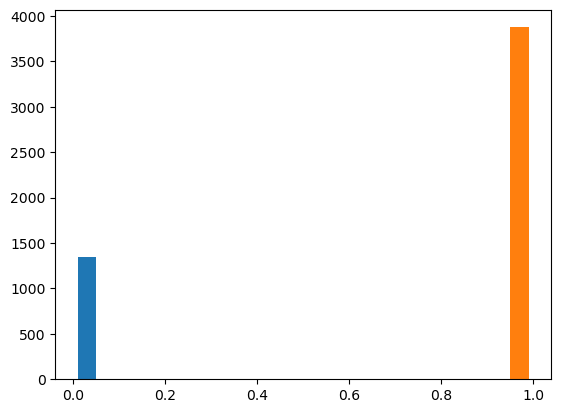

In [7]:
plt.hist((y_train[y_train==0.0],y_train[y_train==1.0]))
plt.show()

We can also take a look at some examples with and without pneumonia:

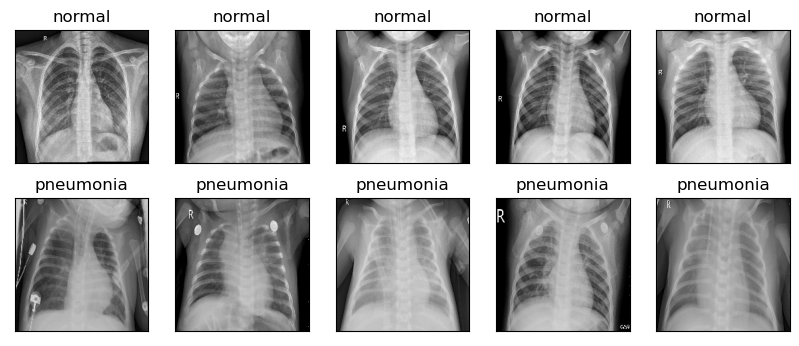

In [8]:
n = 5
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display normal
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[np.where(y_train==0.0)[0][i]],cmap='gray')
    plt.title("normal")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display pneumonia
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train[np.where(y_train==1.0)[0][i]],cmap='gray')
    plt.title("pneumonia")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Data augmentation

In order to avoid overfitting, aside from regularization, we can artifically extend our dataset. This is commonly done with image data, especially when we have only few datapoints. The idea is to alter the training data with small transformations to produce different images every time our fitting process calls up the next batch. In this example, we will:

1. Randomly rotate by up to 30 degrees
1. Randomly zoom by up to 20% some
1. Randomly shift images horizontally by up to 10% of their width
1. Randomly shift images vertically by up to 10% of their height
1. Randomly flip images horizontally.

Note that we are not creating a fixed number of data points. Instead, we create an `ImageDataGenerator`, which is fit to our original training data, and generates new images by randomly applying the different operations mentioned above. It keeps giving out images as long as we are fitting the model.

In [9]:
datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True)  # randomly flip images horizontally

datagen.fit(x_train)

## 3. A standard feed-forward network

Let's start by creating a standard feed-forward network with 3 hidden layers and 100 neurons each, as well as a sigmoid output layer (why?)

Remember that accuracy is an okay indicator (the data is only slightly unbalanced), but we usually care about both specifcity and sensitivity in medical settings. These depend on the threshold chosen, so a good start is the AUC.

In [10]:
model = Sequential([
    Flatten(input_shape=(img_size,img_size,1)),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 100)               4000100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,020,401
Trainable params: 4,020,401
Non-trainable params: 0
_________________________________________________________________


2023-03-29 02:55:14.189585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We next fit the model. We will use a new callback, the `ReduceLROnPlateau`, which observes a certain metric and if this metric no longer improves (considering a certain patience), reduces the learning rate by a given factor. Very similar to the learning rate schedules we have seen before, just some different mechanics.

In [11]:
lr_red_callback = ReduceLROnPlateau(monitor='val_auc', patience = 2, verbose=1,factor=0.3, min_lr=1e-6)

Otherwise, this is the usual process, just that we are not directly inputting our training data, but instead we are providing data from the `ImagaDataGenerator`. We specify a `batch_size` as for the usual fitting process, but this also tells the generator how many images to return at any time.

In [12]:
log = model.fit(datagen.flow(x_train,y_train, batch_size = 128),
                epochs=10,
                validation_data=datagen.flow(x_val,y_val),
                callbacks=[lr_red_callback])

Epoch 1/10
41/41 [==============================] - 15s 339ms/step - loss: 4.0425 - auc: 0.5175 - val_loss: 4.9288 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/10
41/41 [==============================] - 13s 327ms/step - loss: 1.0038 - auc: 0.5173 - val_loss: 1.1543 - val_auc: 0.5781 - lr: 0.0010
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.7074 - auc: 0.5143
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
41/41 [==============================] - 14s 332ms/step - loss: 0.7074 - auc: 0.5143 - val_loss: 1.7977 - val_auc: 0.5781 - lr: 0.0010
Epoch 4/10
41/41 [==============================] - 14s 354ms/step - loss: 0.5356 - auc: 0.6699 - val_loss: 0.8452 - val_auc: 0.7188 - lr: 3.0000e-04
Epoch 5/10
41/41 [==============================] - 14s 339ms/step - loss: 0.5084 - auc: 0.7267 - val_loss: 0.9442 - val_auc: 0.4609 - lr: 3.0000e-04
Epoch 6/10
41/41 [==============================] - 14s 329ms/step - loss: 0.4865 - auc: 0.7701 - val_loss: 

Let's take a look at the AUC:

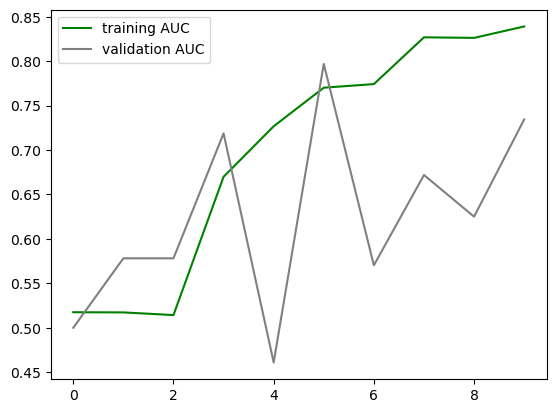

In [13]:
def create_plot(log):
    plt.plot(log.history['auc'],label = "training AUC",color='green')
    plt.plot(log.history['val_auc'], label = "validation AUC",color='grey')
    plt.legend()
    plt.show()
    
create_plot(log)

With a bit of fine-tuning (dropout, batch normalization, a better learning rate, some callbacks), you can reach an AUC of 0.85 or so. Not amazing, but a good start.

Once we are fine with our model, we will evaluate it on the test set

In [14]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 3ms/step - loss: 0.4876 - auc: 0.8470


[0.48763060569763184, 0.8470359444618225]

Let's also take a look at the confusion matrix (from this, we can directly compute specificity and sensitivity):

In [15]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = (predictions > 0.5)
confusion_matrix(y_test,predictions)

20/20 [==============================] - 0s 3ms/step


array([[198,  36],
       [ 89, 301]])

## 4. A convolutional neural network

We will now use convolution and max-pooling layers. As is common, we start with a few (large) channels, then decrease the width and height of our layers, but make them increasingly deep.

At the end, we add a dense layer, as well as the sigmoid output from before.

In [16]:
model_conv = Sequential([
    Conv2D(32, kernel_size=3, strides=2, padding='same', activation="relu", input_shape=(img_size,img_size,1)),
    MaxPool2D((2,2), strides=(2,2), padding='same'),
    
    Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation="relu"),
    MaxPool2D((2,2), strides=(2,2), padding='same'),

    Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation="relu"),
    MaxPool2D((2,2), strides=(2,2), padding='same'),
    
    Flatten(),
    Dense(100, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_conv.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=[tf.keras.metrics.AUC(name='auc')])
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

Training proceeds exactly as before. Note that, even though we have many less parameters, it tends to take much longer to train convlutional neural networks. Be ready to wait a bit (and this is a very simple network, still!)

In [17]:
lr_red_callback = ReduceLROnPlateau(monitor='val_auc', patience = 2, verbose=1,factor=0.3, min_lr=1e-6)

In [19]:
log_conv = model_conv.fit(datagen.flow(x_train,y_train, batch_size = 128),
                            epochs=10,
                            validation_data=datagen.flow(x_val,y_val),
                            callbacks=[lr_red_callback])

Epoch 1/10
41/41 [==============================] - 18s 435ms/step - loss: 0.4042 - auc: 0.8537 - val_loss: 0.6875 - val_auc: 0.8672 - lr: 0.0010
Epoch 2/10
41/41 [==============================] - 17s 418ms/step - loss: 0.3545 - auc: 0.8923 - val_loss: 1.0367 - val_auc: 0.8047 - lr: 0.0010
Epoch 3/10
41/41 [==============================] - 18s 430ms/step - loss: 0.3288 - auc: 0.9087 - val_loss: 0.9475 - val_auc: 0.7500 - lr: 0.0010
Epoch 4/10
41/41 [==============================] - 17s 416ms/step - loss: 0.3077 - auc: 0.9216 - val_loss: 1.1984 - val_auc: 0.6641 - lr: 0.0010
Epoch 5/10
41/41 [==============================] - 17s 419ms/step - loss: 0.3269 - auc: 0.9131 - val_loss: 0.8760 - val_auc: 0.7812 - lr: 0.0010
Epoch 6/10
41/41 [==============================] - ETA: 0s - loss: 0.2592 - auc: 0.9455
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
41/41 [==============================] - 17s 415ms/step - loss: 0.2592 - auc: 0.9455 - val_loss: 1.2715 -

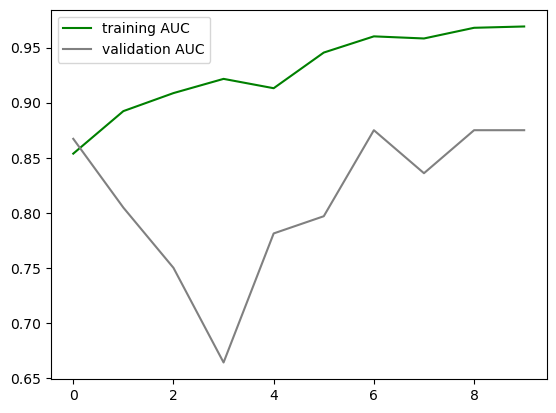

In [20]:
create_plot(log_conv)

The AUC on the validation set looks somewhat better (and also much less variable). There is still a lot to be done. Again, dropout and batch normalization can help, as well as adding more layers. The network presented in the Kaggle notebook linked above gets to around 0.92. With much bigger networks, 0.95 and more should be possible - but we will only use such networks pre-trained, or we could be spending quite some time training.

In [21]:
model_conv.evaluate(x_test, y_test)

20/20 [==============================] - 0s 14ms/step - loss: 0.4031 - auc: 0.9274


[0.40313249826431274, 0.9274380803108215]

In [22]:
predictions = model_conv.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = (predictions > 0.5)
confusion_matrix(y_test,predictions)

20/20 [==============================] - 0s 15ms/step


array([[172,  62],
       [  9, 381]])

### DISCUSSION AND TO DOS

Can you do better? Try adding Dropout and Batch-Normalization layers.

Would you say it is easier or harder to fine-tune a CNN or a normal feed-forward network? Why?



